In [2]:
!pip install wget
!pip install PyGithub
!pip install openpyxl
#!pip install pandas --upgrade

# Import libraries

In [3]:
import os
from os import path

import glob
import pandas as pd
import numpy as np
import wget
from github import Github
import shutil

from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 

import tensorflow as tf

# signal processing
from scipy import signal
from scipy.ndimage import label as sci_label
from scipy.stats import zscore
from scipy.interpolate import interp1d
from scipy.integrate import trapz

# misc
import warnings

Set and clear output directories

In [4]:

if path.exists('Raw Data') == True:
  shutil.rmtree("Raw Data")

if path.exists('Raw Data/Multimodal/ECG/') == False:
  os.mkdir('Raw Data')
  os.mkdir('Raw Data/Multimodal')
  os.mkdir('Raw Data/Multimodal/ECG')
  


if path.exists('Raw Data/Single Modal/ECG') == False:
  os.mkdir('Raw Data/Single Modal')
  os.mkdir('Raw Data/Single Modal/ECG')


# Retrieve datasets

Read xlsx files and convert to csv and transform into datafram for processing

In [5]:
stimulus_desc_file = pd.read_excel('ECG_GSR_Emotions/Stimulus_Description.xlsx')
stimulus_desc_file.to_csv('Stimulus_Description.csv', index = None, header=True)
stimulus_desc = pd.read_csv('Stimulus_Description.csv')
#stimulus_desc.head()

In [6]:
self_annotation_multimodal_file = pd.read_excel('ECG_GSR_Emotions/Self-Annotation Labels/Self-annotation Multimodal_Use.xlsx')
self_annotation_multimodal_file.to_csv('Self-annotation Multimodal_Use.csv', index = None, header=True)
self_annotation_multimodal = pd.read_csv('Self-annotation Multimodal_Use.csv')
self_annotation_multimodal['annotation'] = 'M'
self_annotation_multimodal.rename(columns = {'V_Label':'Valence', 'A_Label':'Arousal', 'Four_Labels':'Four_Label'}, inplace = True)
#self_annotation_multimodal.head()

In [7]:
self_annotation_singlemodal_file = pd.read_excel('ECG_GSR_Emotions/Self-Annotation Labels/Self-annotation Single Modal_Use.xlsx')
self_annotation_singlemodal_file.to_csv('Self-annotation Single Modal_Use.csv', index = None, header=True)
self_annotation_singlemodal = pd.read_csv('Self-annotation Single Modal_Use.csv')
self_annotation_singlemodal['annotation'] = 'S'
self_annotation_singlemodal.rename(columns = {'Male':'Gender', 'Session Id':'Session ID', 'Video Id':'Video ID'}, inplace = True)
#self_annotation_singlemodal.head()

In [8]:
self_annotation_frames = [self_annotation_multimodal, self_annotation_singlemodal]
merged_dataframe = pd.concat(self_annotation_frames)
#merged_dataframe.head()
#merged_dataframe.tail()
table_frame = merged_dataframe.copy()

In [9]:
cols = []
cols.append('Raw Data')
for col in merged_dataframe.columns:
    cols.append(col)

# Data processing

Processed data: Collected ECG signals are converted into numerical series data values.

In [10]:
arr_shape = 1000
raw_data_arr = []

def form_data(data_array = [], annotation = '', data_path = ''):

    for filename in os.listdir(data_path):
            data = np.loadtxt(os.path.join(data_path, filename), delimiter=',')
            data = data[0:arr_shape]
            filenames = filename.split('ECGdata_')[1]
            filenames = filenames.split('.dat')[0]
            filenames = filenames.lower()
            s = filenames.split('s')[1].split('p');
            p = s[1].split('v')
            s = s[0]
            v = p[1]
            p = p[0]
            data_row = merged_dataframe.loc[(merged_dataframe['Session ID'] == int(s)) & 
                             (merged_dataframe['Participant Id'] == int(p)) & 
                             (merged_dataframe['Video ID'] == int(v)) &
                             (merged_dataframe['annotation'] == 'M')]
            stim_row = stimulus_desc.loc[(stimulus_desc['Session ID'] == int(s)) & 
                             (stimulus_desc['Video ID'] == int(v))]
            for index, row in data_row.iterrows():
              data_array.append([data, 
                                   row['Participant Id'], row['Session ID'], row['Video ID'],
                                   row['Name'], row['Age'], row['Gender'], row['Valence level'],
                                   row['Arousal level'], row['Dominance level'], row['Happy'],
                                   row['Sad'], row['Fear'], row['Anger'], row['Neutral'],
                                   row['Disgust'], row['Surprised'], row['Familiarity Score'],
                                   row['Emotion'], row['Valence'], row['Arousal'], row['Four_Label'],
                                   row['annotation'],  stim_row['Target Emotion'].iat[0]
                                   ])
    return data_array

    
raw_data_arr =  form_data(data_array = raw_data_arr, annotation = 'M', data_path = "ECG_GSR_Emotions/Raw Data/Multimodal/ECG/")
raw_data_arr =  form_data(data_array = raw_data_arr, annotation = 'S', data_path = "ECG_GSR_Emotions/Raw Data/Single Modal/ECG/")
cols.append('Target Emotion')
raw_dataframe = pd.DataFrame(raw_data_arr, columns = cols)
raw_dataframe.rename(columns = {'Participant Id':'Participant ID', 'annotation':'Modal', 'Four_Label':'Four label'}, inplace = True)
raw_dataframe['Familiarity Score'] = raw_dataframe['Familiarity Score'].fillna('Never watched')
raw_dataframe = raw_dataframe.replace(np.nan, '', regex=True)
raw_dataframe.head()

,Raw Data,Participant ID,Session ID,Video ID,Name,Age,Gender,Valence level,Arousal level,Dominance level,...,Neutral,Disgust,Surprised,Familiarity Score,Emotion,Valence,Arousal,Four label,Modal,Target Emotion
0,"[-18.702, -18.694, -18.692, -18.678, -18.665, ...",10,1,1,S_D,8,Male,8,3,0,...,VeryLow,VeryLow,VeryLow,Never watched,Happy,HV,LA,HVLA,M,happy
1,"[-18.702, -18.694, -18.692, -18.678, -18.665, ...",10,1,1,S_D,8,Male,9,7,0,...,VeryLow,VeryLow,VeryLow,Never watched,Happy,HV,HA,HVHA,M,happy
2,"[-18.619, -18.624, -18.615, -18.604, -18.616, ...",10,1,2,S_D,8,Male,5,4,2,...,Low,VeryLow,Low,Never watched,Mixed,LV,LA,LVLA,M,sad
3,"[-18.705, -18.669, -18.642, -18.586, -18.552, ...",10,1,3,S_D,8,Male,4,0,0,...,VeryHigh,VeryLow,VeryLow,Never watched,Neutral,LV,LA,LVLA,M,neutral
4,"[-18.561, -18.561, -18.557, -18.557, -18.545, ...",10,1,4,S_D,8,Male,7,6,0,...,VeryLow,VeryLow,VeryHigh,Never watched,Surprise,HV,HA,HVHA,M,surprise


# Data visualization

Using Matplotlib, we can visualized the data/signals per emotion into signal waves

In [11]:
plot_frame = raw_dataframe.copy()
plot_frame.head()

,Raw Data,Participant ID,Session ID,Video ID,Name,Age,Gender,Valence level,Arousal level,Dominance level,...,Neutral,Disgust,Surprised,Familiarity Score,Emotion,Valence,Arousal,Four label,Modal,Target Emotion
0,"[-18.702, -18.694, -18.692, -18.678, -18.665, ...",10,1,1,S_D,8,Male,8,3,0,...,VeryLow,VeryLow,VeryLow,Never watched,Happy,HV,LA,HVLA,M,happy
1,"[-18.702, -18.694, -18.692, -18.678, -18.665, ...",10,1,1,S_D,8,Male,9,7,0,...,VeryLow,VeryLow,VeryLow,Never watched,Happy,HV,HA,HVHA,M,happy
2,"[-18.619, -18.624, -18.615, -18.604, -18.616, ...",10,1,2,S_D,8,Male,5,4,2,...,Low,VeryLow,Low,Never watched,Mixed,LV,LA,LVLA,M,sad
3,"[-18.705, -18.669, -18.642, -18.586, -18.552, ...",10,1,3,S_D,8,Male,4,0,0,...,VeryHigh,VeryLow,VeryLow,Never watched,Neutral,LV,LA,LVLA,M,neutral
4,"[-18.561, -18.561, -18.557, -18.557, -18.545, ...",10,1,4,S_D,8,Male,7,6,0,...,VeryLow,VeryLow,VeryHigh,Never watched,Surprise,HV,HA,HVHA,M,surprise


In [12]:
plot_frame = plot_frame.drop(['Participant ID', 'Session ID', 'Familiarity Score', 'Age', 'Gender', 'Name'], axis = 1)
sad_data = plot_frame.loc[(plot_frame['Emotion'] == 'Sad') & (plot_frame['Target Emotion'] == 'sad')] 
fear_data = plot_frame.loc[(plot_frame['Emotion'] == 'Fear')  & (plot_frame['Target Emotion'] == 'fear')]
happy_data = plot_frame.loc[(plot_frame['Emotion'] == 'Happy') & (plot_frame['Target Emotion'] == 'happy')]
anger_data = plot_frame.loc[(plot_frame['Emotion'] == 'Anger') & (plot_frame['Target Emotion'] == 'anger')]
neutral_data = plot_frame.loc[(plot_frame['Emotion'] == 'Neutral') & (plot_frame['Target Emotion'] == 'neutral')]
mixed_data = plot_frame.loc[(plot_frame['Emotion'] == 'Mixed') & (plot_frame['Target Emotion'] == 'neutral')]
disgust_data = plot_frame.loc[(plot_frame['Emotion'] == 'Disgust') & (plot_frame['Target Emotion'] == 'disgust')]
surprised_data = plot_frame.loc[(plot_frame['Emotion'] == 'Surprise') & (plot_frame['Target Emotion'] == 'surprise')]

In [13]:
def plot_signals(data_arr, title = ''):
    plt.clf()
    plt.figure(figsize=(12, 4))
    
    for index, row in data_arr.iterrows():
        y = row['Raw Data']
        plt.plot(y)
        #x = np.arange(y.size)
        #plt.plot(x, y)
    
    plt.tight_layout()
    plt.title(title)
    plt.show()

**SAD**

<Figure size 640x480 with 0 Axes>

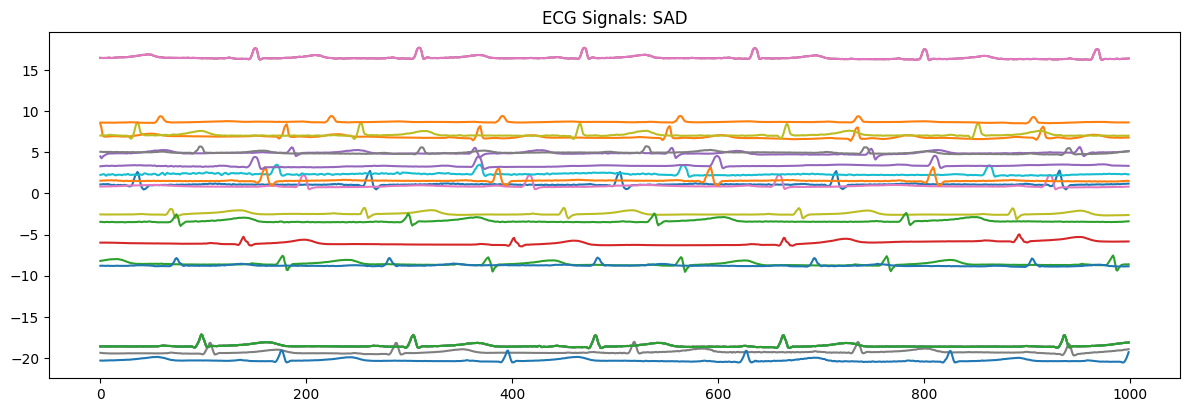

In [14]:
plot_signals(data_arr = sad_data, title = 'ECG Signals: SAD')

**FEAR**

<Figure size 640x480 with 0 Axes>

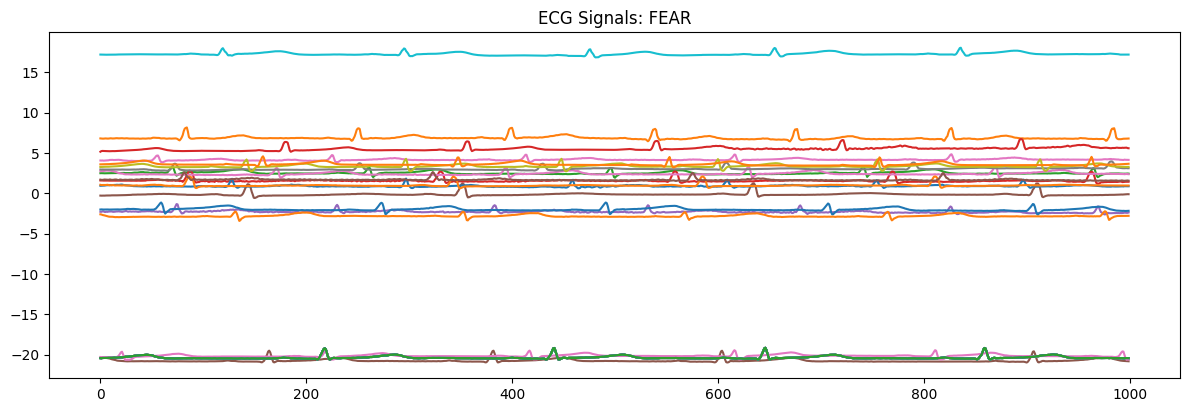

In [15]:
plot_signals(data_arr = fear_data, title = 'ECG Signals: FEAR')

**HAPPY**: Signals scatters on different levels

<Figure size 640x480 with 0 Axes>

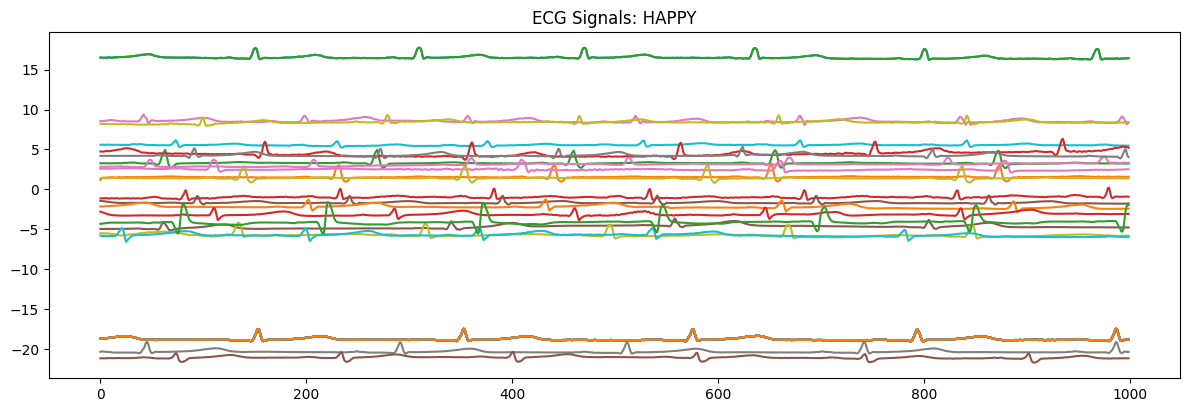

In [16]:
plot_signals(data_arr = happy_data, title = 'ECG Signals: HAPPY')

**ANGER**: Signals scatters on different levels

<Figure size 640x480 with 0 Axes>

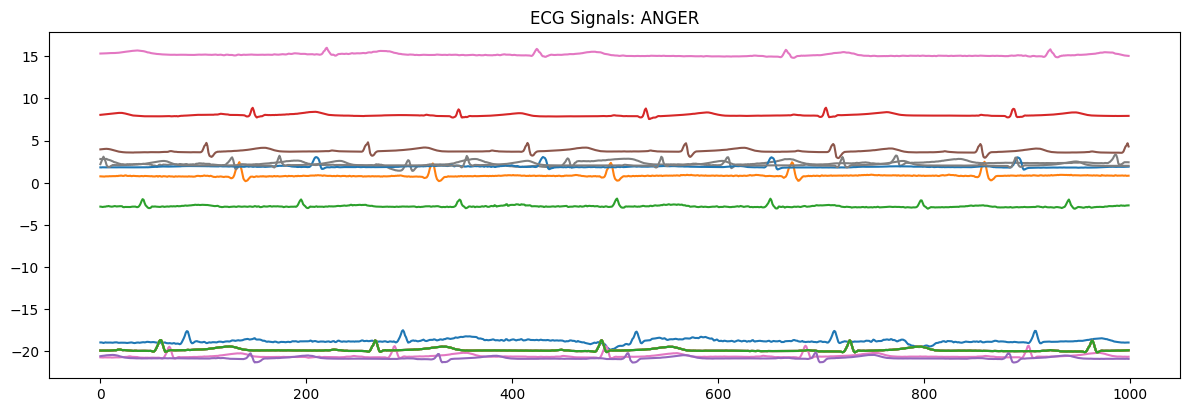

In [17]:
plot_signals(data_arr = anger_data, title = 'ECG Signals: ANGER')

**NEUTRAL**: Signals above 0 region are scatterd. Some are on -15 to -20 area

<Figure size 640x480 with 0 Axes>

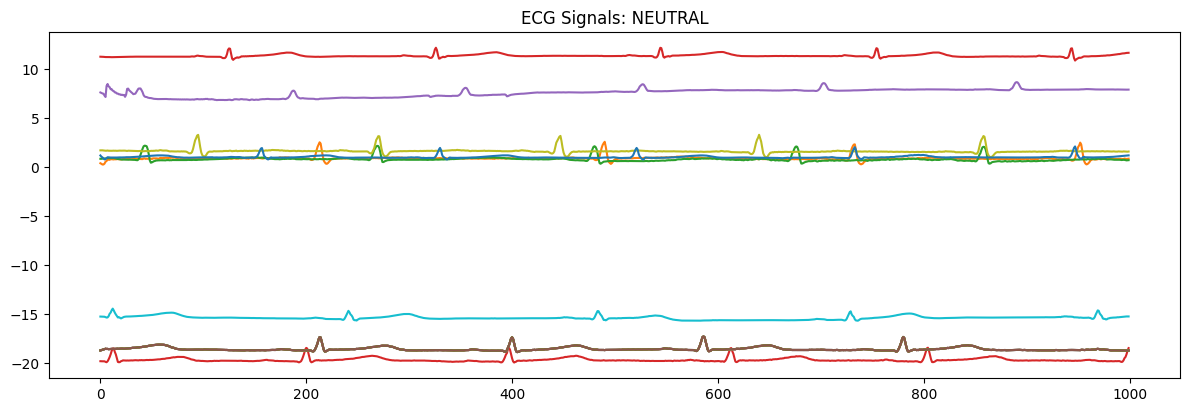

In [18]:
plot_signals(data_arr = neutral_data, title = 'ECG Signals: NEUTRAL')

**MIXED**: Most signals resides on zero level

<Figure size 640x480 with 0 Axes>

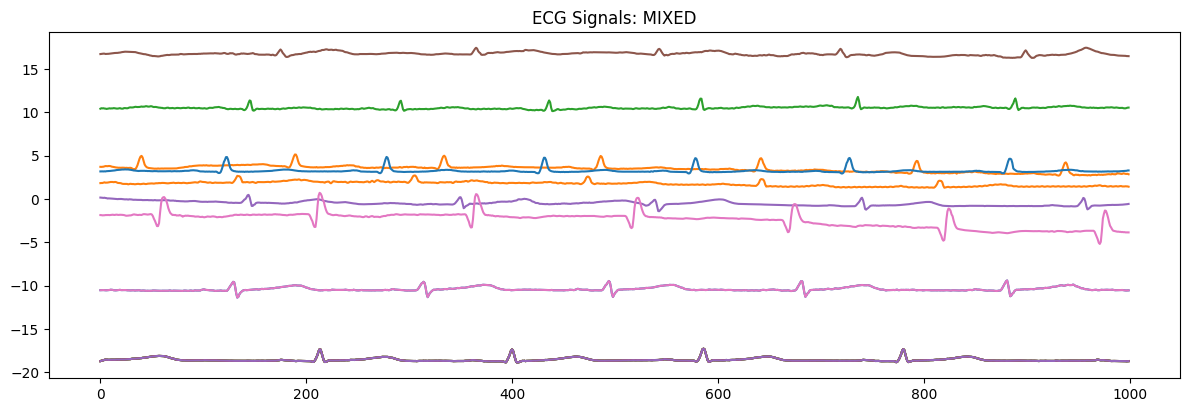

In [19]:
plot_signals(data_arr = mixed_data, title = 'ECG Signals: MIXED')

**DISGUST** : Signals are on 0-5 region and a lot on -20 level

<Figure size 640x480 with 0 Axes>

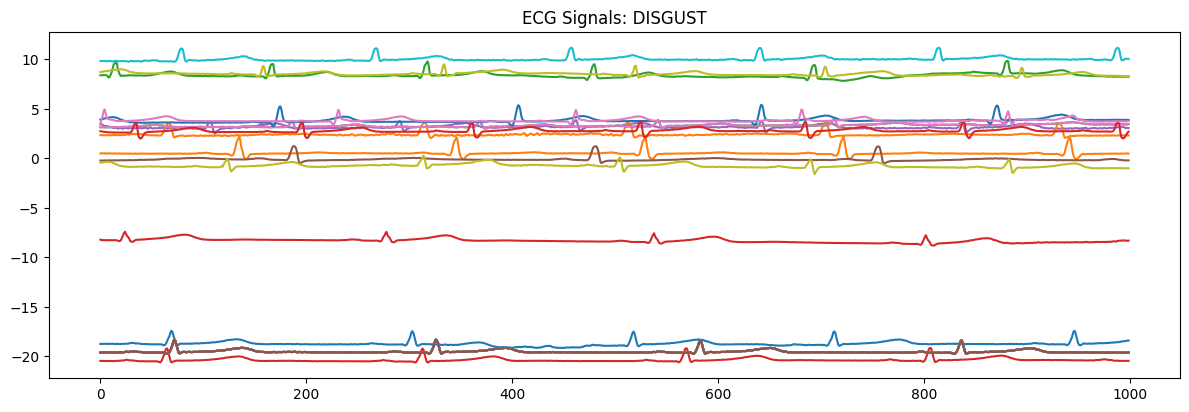

In [20]:
plot_signals(data_arr = disgust_data, title = 'ECG Signals: DISGUST')

**SURPRISED** : signals are all similar and residing near zero region

<Figure size 640x480 with 0 Axes>

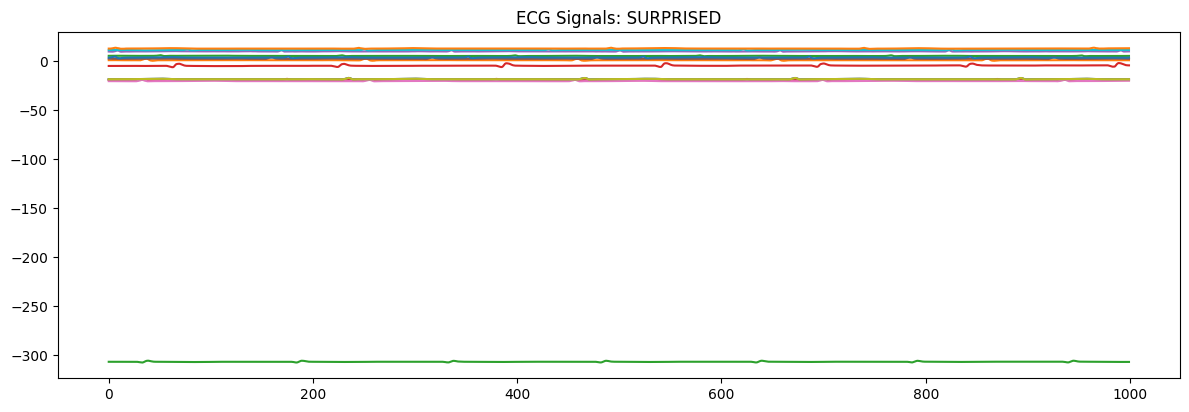

In [21]:
plot_signals(data_arr = surprised_data, title = 'ECG Signals: SURPRISED')

**Findings:** Uncertain on possible recognized pattern based on visual representation of the data

# Model creation and training

In [22]:

train_d_frame = plot_frame.copy().drop(['Video ID', 'Happy', 'Sad', 'Fear',
                                        'Anger', 'Neutral', 'Disgust', 'Surprised', 'Four label', 'Modal'
                                       ], axis = 1)
train_d_frame.rename(columns = {'Raw Data':'feature', 'Emotion':'emotion'}, inplace = True)
train_d_frame.head()


,feature,Valence level,Arousal level,Dominance level,emotion,Valence,Arousal,Target Emotion
0,"[-18.702, -18.694, -18.692, -18.678, -18.665, ...",8,3,0,Happy,HV,LA,happy
1,"[-18.702, -18.694, -18.692, -18.678, -18.665, ...",9,7,0,Happy,HV,HA,happy
2,"[-18.619, -18.624, -18.615, -18.604, -18.616, ...",5,4,2,Mixed,LV,LA,sad
3,"[-18.705, -18.669, -18.642, -18.586, -18.552, ...",4,0,0,Neutral,LV,LA,neutral
4,"[-18.561, -18.561, -18.557, -18.557, -18.545, ...",7,6,0,Surprise,HV,HA,surprise


In [23]:
x = np.array(train_d_frame['feature'].tolist())
y = np.array(train_d_frame['emotion'].tolist())

In [24]:
sc = StandardScaler()
x = sc.fit_transform(x)

In [25]:
labelencoder = LabelEncoder()
y = to_categorical(labelencoder.fit_transform(y))

Split the dataset into training and testing dataset

In [26]:

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 0) 

In [27]:
num_labels = y.shape[1]
num_labels

8

In [28]:
arr_shape

1000

Create model

In [29]:
# TAMBAHAN/EDITED - activation dari hidden layer sebelumnya adalah relu

model = Sequential()

##first layer
model.add(Dense(1, input_shape = (arr_shape,)))
model.add(Activation('sigmoid'))  # (TAMBAHAN/EDITED)

##second layer
model.add(Dense(2))
model.add(Activation('sigmoid'))  # (TAMBAHAN/EDITED)

##third layer
model.add(Dense(4))
model.add(Activation('sigmoid'))  # (TAMBAHAN/EDITED)

##fourth layer
model.add(Dense(8))
model.add(Activation('sigmoid'))  # (TAMBAHAN/EDITED)

##final layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 1001      
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
 dense_1 (Dense)             (None, 2)                 4         
                                                                 
 activation_1 (Activation)   (None, 2)                 0         
                                                                 
 dense_2 (Dense)             (None, 4)                 12        
                                                                 
 activation_2 (Activation)   (None, 4)                 0         
                                                                 
 dense_3 (Dense)             (None, 8)                 4

In [31]:
# model.compile(loss = 'categorical_crossentropy', metrics = ['accuracy'], optimizer = 'adam')
model.compile(loss = 'categorical_crossentropy', metrics = ['accuracy'], optimizer = 'RMSProp') #TAMBAHAN/EDITED

In [32]:
num_epochs = 15 # (TAMBAHAN/EDITED)
num_batch_size = 3 # (TAMBAHAN/EDITED)

checkpointer = ModelCheckpoint(filepath = './Raw Data/ecg_emotion_recognizer.hdf5', 
                              verbose = 1, save_best_only = True)
start = datetime.now()

model.fit(x_train, y_train, batch_size = num_batch_size, epochs = num_epochs,
         validation_data = (x_test, y_test), callbacks = [checkpointer], verbose = 1)

duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/15




78/93 [========================>.....] - ETA: 0s - loss: 2.2369 - accuracy: 0.0940  
Epoch 1: val_loss improved from inf to 2.11102, saving model to ./Raw Data\ecg_emotion_recognizer.hdf5
93/93 [==============================] - 3s 9ms/step - loss: 2.2235 - accuracy: 0.0968 - val_loss: 2.1110 - val_accuracy: 0.0917
Epoch 2/15
63/93 [===================>..........] - ETA: 0s - loss: 2.0976 - accuracy: 0.1164  

c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


93/93 [==============================] - ETA: 0s - loss: 2.0840 - accuracy: 0.1577
Epoch 2: val_loss improved from 2.11102 to 2.02245, saving model to ./Raw Data\ecg_emotion_recognizer.hdf5
93/93 [==============================] - 0s 3ms/step - loss: 2.0840 - accuracy: 0.1577 - val_loss: 2.0224 - val_accuracy: 0.2750
Epoch 3/15
79/93 [========================>.....] - ETA: 0s - loss: 2.0262 - accuracy: 0.2700
Epoch 3: val_loss improved from 2.02245 to 1.97953, saving model to ./Raw Data\ecg_emotion_recognizer.hdf5
93/93 [==============================] - 0s 3ms/step - loss: 2.0090 - accuracy: 0.2832 - val_loss: 1.9795 - val_accuracy: 0.2750
Epoch 4/15
86/93 [==========================>...] - ETA: 0s - loss: 1.9806 - accuracy: 0.2791
Epoch 4: val_loss improved from 1.97953 to 1.96104, saving model to ./Raw Data\ecg_emotion_recognizer.hdf5
93/93 [==============================] - 0s 4ms/step - loss: 1.9725 - accuracy: 0.2832 - val_loss: 1.9610 - val_accuracy: 0.2750
Epoch 5/15
91/93 [===

# Model accuracy

In [33]:
test_accuracy = model.evaluate(x_test, y_test, verbose = 0)
print(test_accuracy)

[1.9595777988433838, 0.2750000059604645]


# Initial Findings

**Initial Findings**: Model displayed low accuracy. Need to look for possible improvements. Will try feature extraction on raw data signals.

In [34]:
from __future__ import division
from matplotlib import pyplot as plt
import scipy.io as spio
import numpy as np
import statistics
from scipy.stats import kurtosis
from scipy.stats import skew
import sys
#sys.path.append("/home/chandan/python-workspace/")
# import BOCPD as ocpd #import bocpd from another file
import cProfile
from functools import partial

In [35]:

## Reference: https://github.com/chandanacharya1/ECG-Feature-extraction-using-Python/blob/master/features.py
####################### FEATURE DEFINITIONS ###################################


def detect_peaks(ecg_signal, threshold=0.3, qrs_filter=None):
    '''
    Peak detection algorithm using cross corrrelation and threshold 
    '''
    if qrs_filter is None:
        # create default qrs filter, which is just a part of the sine function
        t = np.linspace(1.5 * np.pi, 3.5 * np.pi, 15)
        qrs_filter = np.sin(t)
    
    # normalize data
    ecg_signal = (ecg_signal - ecg_signal.mean()) / ecg_signal.std()

    # calculate cross correlation
    similarity = np.correlate(ecg_signal, qrs_filter, mode="same")
    similarity = similarity / np.max(similarity)

    # return peaks (values in ms) using threshold
    return ecg_signal[similarity > threshold].index, similarity

def group_peaks(p, threshold=5):
    '''
    The peak detection algorithm finds multiple peaks for each QRS complex. 
    Here we group collections of peaks that are very near (within threshold) and we take the median index 
    '''
    # initialize output
    output = np.empty(0)

    # label groups of sample that belong to the same peak
    peak_groups, num_groups = sci_label(np.diff(p) < threshold)
 
    # iterate through groups and take the mean as peak index
    for i in np.unique(peak_groups)[1:]:
    #for i in np.unique(peak_groups):    
        peak_group = p[np.where(peak_groups == i)]
        output = np.append(output, np.median(peak_group))
    return output

"""TIME DOMAIN"""
#independent function to calculate RMSSD
def calc_rmssd(list):
    diff_nni = np.diff(list)#successive differences
    return np.sqrt(np.mean(diff_nni ** 2))
    
    
 #independent function to calculate AVRR   
def calc_avrr(list):
    return sum(list)/len(list)

 #independent function to calculate SDRR   
def calc_sdrr(list):
    return statistics.stdev(list)

 #independent function to calculate SKEW   
def calc_skew(list):
    return skew(list)

 #independent function to calculate KURT   
def calc_kurt(list):
    return kurtosis(list)

def calc_NNx(list):
    #diff_nni = np.diff(list)
    # detect peaks
    peaks, similarity = detect_peaks(list, threshold=0.3)
    # group peaks so we get a single peak per beat (hopefully)
    grouped_peaks = group_peaks(peaks)
    # RR-intervals are the differences between successive peaks
    rr = np.diff(grouped_peaks)
    nnxx = np.sum(np.abs(np.diff(rr)) > 50)*1
    #return sum(np.abs(diff_nni) > 50)
    return nnxx
    
def calc_pNNx(list):
    #length_int = len(list)
    #diff_nni = np.diff(list)
    #nni_50 = sum(np.abs(diff_nni) > 50)
    #return 100 * nni_50 / length_int
    # detect peaks
    peaks, similarity = detect_peaks(list, threshold=0.3)
    # group peaks so we get a single peak per beat (hopefully)
    grouped_peaks = group_peaks(peaks)
    # RR-intervals are the differences between successive peaks
    rr = np.diff(grouped_peaks)
    pnnxx = 100 * np.sum((np.abs(np.diff(rr)) > 50)*1) / len(rr)
    #return sum(np.abs(diff_nni) > 50)
    return pnnxx
    
"""NON LINEAR DOMAIN"""
 #independent function to calculate SD1
def calc_SD1(list):
    diff_nn_intervals = np.diff(list)
    return np.sqrt(np.std(diff_nn_intervals, ddof=1) ** 2 * 0.5)
 #independent function to calculate SD2
def calc_SD2(list):
    diff_nn_intervals = np.diff(list)
    return np.sqrt(2 * np.std(list, ddof=1) ** 2 - 0.5 * np.std(\
                   diff_nn_intervals, ddof=1) ** 2)
    
 #independent function to calculate SD1/SD2
def calc_SD1overSD2(list):
      diff_nn_intervals = np.diff(list)
      sd1 = np.sqrt(np.std(diff_nn_intervals, ddof=1) ** 2 * 0.5)
      sd2 = np.sqrt(2 * np.std(list, ddof=1) ** 2 - 0.5 * np.std(\
                    diff_nn_intervals, ddof=1) ** 2)
      ratio_sd2_sd1 = sd2 / sd1
      return ratio_sd2_sd1
    
    
 #independent function to calculate CSI
def calc_CSI(list):
    diff_nn_intervals = np.diff(list)
    sd1 = np.sqrt(np.std(diff_nn_intervals, ddof=1) ** 2 * 0.5)
    sd2 = np.sqrt(2 * np.std(list, ddof=1) ** 2 - 0.5 * np.std(\
                  diff_nn_intervals, ddof=1) ** 2)
    L=4 * sd1
    T=4 * sd2
    return L/T
       
 #independent function to calculate CVI
def calc_CVI(list):
    diff_nn_intervals = np.diff(list)
    sd1 = np.sqrt(np.std(diff_nn_intervals, ddof=1) ** 2 * 0.5)
    sd2 = np.sqrt(2 * np.std(list, ddof=1) ** 2 - 0.5 * np.std(\
                  diff_nn_intervals, ddof=1) ** 2)
    L=4 * sd1
    T=4 * sd2
    return np.log10(L * T)
 
 #independent function to calculate modified CVI
def calc_modifiedCVI(list):
    diff_nn_intervals = np.diff(list)
    sd1 = np.sqrt(np.std(diff_nn_intervals, ddof=1) ** 2 * 0.5)
    sd2 = np.sqrt(2 * np.std(list, ddof=1) ** 2 - 0.5 * np.std(\
                  diff_nn_intervals, ddof=1) ** 2)
    L=4 * sd1
    T=4 * sd2
    return L ** 2 / T


def calc_meanrr(list):
    # detect peaks
    peaks, similarity = detect_peaks(list, threshold=0.3)
    # group peaks so we get a single peak per beat (hopefully)
    grouped_peaks = group_peaks(peaks)
    # RR-intervals are the differences between successive peaks
    rr = np.diff(grouped_peaks)
    return np.mean(rr)

def calc_medianrr(list):
    # detect peaks
    peaks, similarity = detect_peaks(list, threshold=0.3)
    # group peaks so we get a single peak per beat (hopefully)
    grouped_peaks = group_peaks(peaks)
    # RR-intervals are the differences between successive peaks
    rr = np.diff(grouped_peaks)
    return np.median(rr)

    
def calc_hr(list):
    # detect peaks
    peaks, similarity = detect_peaks(list, threshold=0.3)
    # group peaks so we get a single peak per beat (hopefully)
    grouped_peaks = group_peaks(peaks)
    # RR-intervals are the differences between successive peaks
    rr = np.diff(grouped_peaks)
    hr = 60000/rr
    return np.mean(hr) 

    

In [36]:
extract_frame = train_d_frame.copy()
#hrv_data = train_d_frame.copy()

medianrr = []
meanrr = []
rmssd = []
sdrr_rmssd = []
hr = []
avrr = []
sdrr = []
skew_ = []
kurt = []
NNx = []
pNNx = []
SD1 = []
SD2 = []
CSI = []
CVI = []
modifiedCVI = []
SD1overSD2 = []
for index, row in extract_frame.iterrows():
    rmssd.append(calc_rmssd(row['feature']))
    avrr.append(calc_avrr(row['feature']))
    sdrr.append(calc_sdrr(row['feature']))
    skew_.append(calc_skew(row['feature']))
    kurt.append(calc_kurt(row['feature']))
    NNx.append(calc_NNx(pd.Series(row['feature'])))
    pNNx.append(calc_pNNx(pd.Series(row['feature'])))
    SD1.append(calc_SD1(row['feature']))
    SD2.append(calc_SD2(row['feature']))
    CSI.append(calc_CSI(row['feature']))
    CVI.append(calc_CVI(row['feature']))
    modifiedCVI.append(calc_modifiedCVI(row['feature']))
    SD1overSD2.append(calc_SD1overSD2(row['feature']))
    meanrr.append(calc_meanrr(pd.Series(row['feature'])))
    medianrr.append(calc_medianrr(pd.Series(row['feature'])))
    hr.append(calc_hr(pd.Series(row['feature'])))
    sdrrrmssd = calc_sdrr(row['feature']) / calc_rmssd(row['feature'])
    sdrr_rmssd.append(sdrrrmssd)
    

extract_frame['meanrr'] = meanrr
extract_frame['medianrr'] = medianrr
extract_frame['sdrr'] = sdrr
extract_frame['rmssd'] = rmssd
extract_frame['sdrr_rmssd'] = sdrr_rmssd
extract_frame['hr'] = hr
extract_frame['NNx'] = NNx
extract_frame['pNNx'] = pNNx
extract_frame['sd1'] = SD1
extract_frame['sd2'] = SD2
extract_frame['avrr'] = avrr
extract_frame['skew'] = skew_
extract_frame['kurt'] = kurt
extract_frame['avrr'] = avrr
extract_frame['csi'] = CSI
extract_frame['cvi'] = CVI
extract_frame['modifiedcvi'] = modifiedCVI

extract_frame = extract_frame.drop(['Valence level', 'Arousal level', 'Dominance level'], axis = 1)
extract_frame2 = extract_frame.copy()
extract_frame = extract_frame.drop(['feature', 'Target Emotion'], axis = 1)
extract_frame = extract_frame.drop(['Valence', 'Arousal'], axis = 1)
extract_frame = extract_frame.drop(['avrr', 'csi', 'cvi', 'modifiedcvi'], axis = 1)
extract_frame.head()

,emotion,meanrr,medianrr,sdrr,rmssd,sdrr_rmssd,hr,NNx,pNNx,sd1,sd2,skew,kurt
0,Happy,208.375,209.00,0.217225,0.071985,3.017659,288.973793,0,0.0,0.050926,0.302952,3.058683,12.166933
1,Happy,208.375,209.00,0.217225,0.071985,3.017659,288.973793,0,0.0,0.050926,0.302952,3.058683,12.166933
2,Mixed,209.625,194.25,0.221027,0.072777,3.037027,294.650732,1,25.0,0.051486,0.308310,3.158817,12.848869
3,Neutral,189.000,186.50,0.205307,0.064151,3.200358,317.593251,0,0.0,0.045385,0.286779,2.862825,11.344312
4,Surprise,219.500,221.50,0.197991,0.062261,3.180001,273.960919,0,0.0,0.044048,0.276516,2.842292,11.033996


In [37]:
from sklearn import preprocessing
import seaborn as sns

In [38]:
#extract_frame = extract_frame2.drop(['feature'], axis = 1)
#extract_frame = extract_frame2.drop(['Target Emotion'], axis = 1)
le = preprocessing.LabelEncoder()
le.fit(extract_frame['emotion'])
extract_frame['emotion'] = le.transform(extract_frame['emotion'])


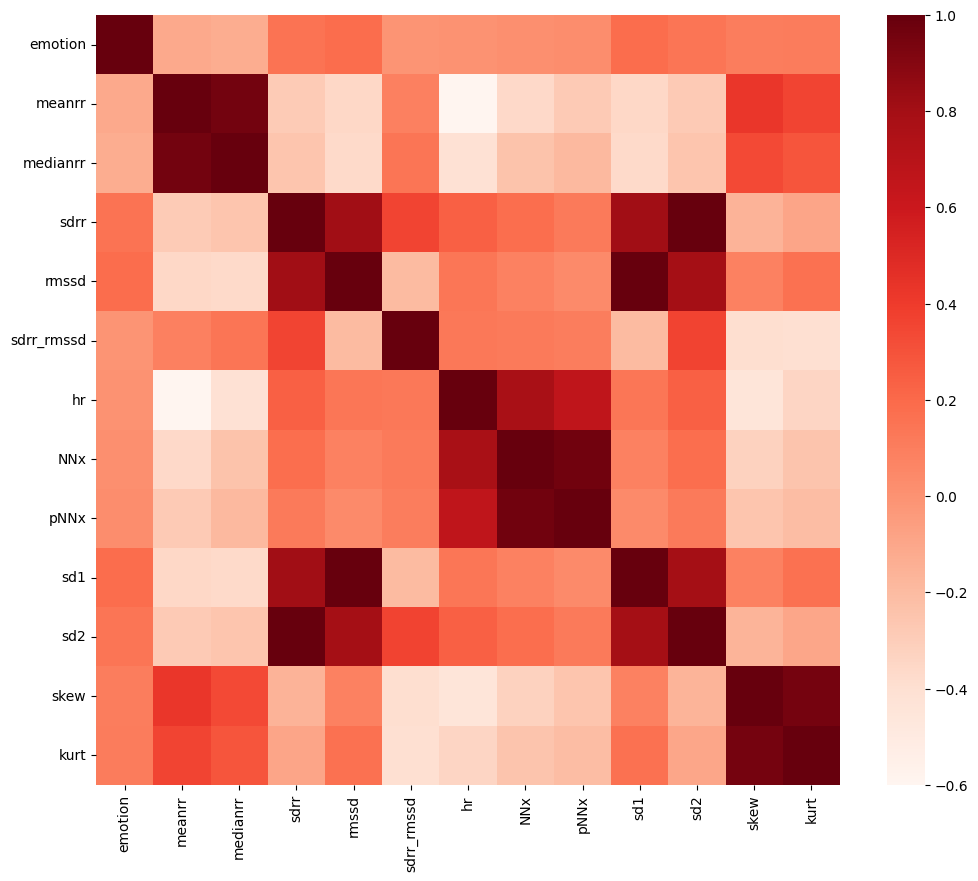

In [39]:
plt.figure(figsize=(12,10))
corr = extract_frame.corr()
sns.heatmap(corr, annot=False, cmap=plt.cm.Reds)
plt.show()

In [40]:
def feature_selection(correlation, threshold):
    selected_features = []
    for i in range(corr.shape[0]):
      if corr.iloc[i,0] > threshold:
        selected_features.append(extract_frame.iloc[:,i])
    return pd.DataFrame(selected_features).T

In [41]:
extract_frame.head()

,emotion,meanrr,medianrr,sdrr,rmssd,sdrr_rmssd,hr,NNx,pNNx,sd1,sd2,skew,kurt
0,3,208.375,209.00,0.217225,0.071985,3.017659,288.973793,0,0.0,0.050926,0.302952,3.058683,12.166933
1,3,208.375,209.00,0.217225,0.071985,3.017659,288.973793,0,0.0,0.050926,0.302952,3.058683,12.166933
2,4,209.625,194.25,0.221027,0.072777,3.037027,294.650732,1,25.0,0.051486,0.308310,3.158817,12.848869
3,5,189.000,186.50,0.205307,0.064151,3.200358,317.593251,0,0.0,0.045385,0.286779,2.862825,11.344312
4,7,219.500,221.50,0.197991,0.062261,3.180001,273.960919,0,0.0,0.044048,0.276516,2.842292,11.033996


In [42]:
# CORRELATION_THRESHOLD = 0.1
# extract_frame = feature_selection(extract_frame, CORRELATION_THRESHOLD)
x = extract_frame.drop(['emotion'],axis=1)
y = extract_frame['emotion']
# train_x, test_x, train_y, test_y = train_test_split(x, y, train_size=0.8, test_size=0.2, random_state=0)
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.3, random_state=0) # TAMBAHAN/EDITED

extract_frame.head()

,emotion,meanrr,medianrr,sdrr,rmssd,sdrr_rmssd,hr,NNx,pNNx,sd1,sd2,skew,kurt
0,3,208.375,209.00,0.217225,0.071985,3.017659,288.973793,0,0.0,0.050926,0.302952,3.058683,12.166933
1,3,208.375,209.00,0.217225,0.071985,3.017659,288.973793,0,0.0,0.050926,0.302952,3.058683,12.166933
2,4,209.625,194.25,0.221027,0.072777,3.037027,294.650732,1,25.0,0.051486,0.308310,3.158817,12.848869
3,5,189.000,186.50,0.205307,0.064151,3.200358,317.593251,0,0.0,0.045385,0.286779,2.862825,11.344312
4,7,219.500,221.50,0.197991,0.062261,3.180001,273.960919,0,0.0,0.044048,0.276516,2.842292,11.033996


Menghitung jumlah label tiap data train dan test :

In [43]:
train_y.value_counts()

3    79
4    59
6    27
1    27
2    24
7    23
5    22
0    18
Name: emotion, dtype: int64

In [44]:
test_y.value_counts()

3    33
4    25
2    14
5    14
6    11
0    10
1     7
7     6
Name: emotion, dtype: int64

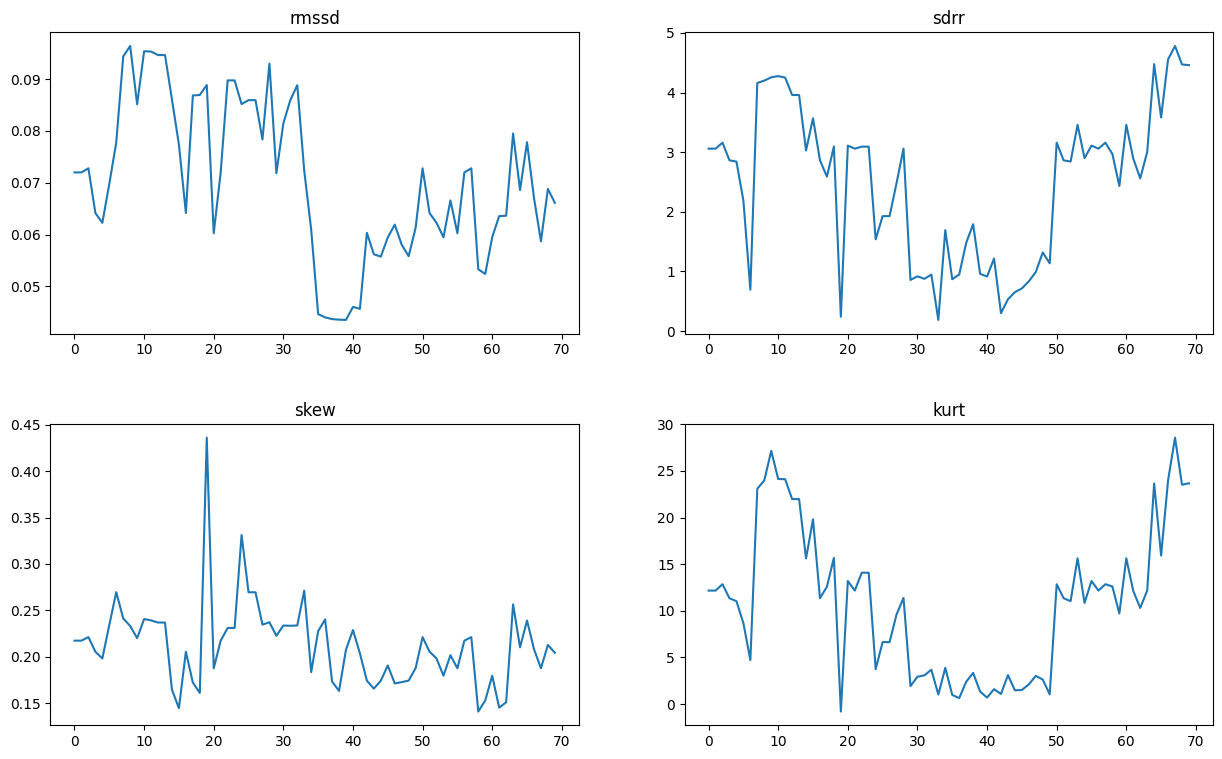

In [45]:
fig, axarr = plt.subplots(2, 2, figsize=(15, 9))
extract_frame['rmssd'][:70].plot(ax=axarr[0][0])
extract_frame['sdrr'][:70].plot(ax=axarr[1][0])
extract_frame['skew'][:70].plot(ax=axarr[0][1])
extract_frame['kurt'][:70].plot(ax=axarr[1][1])
axarr[0][0].set_title("rmssd")
axarr[0][1].set_title("sdrr")
axarr[1][0].set_title("skew")
axarr[1][1].set_title("kurt")
plt.subplots_adjust(hspace=.3)

In [46]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier


dt_model = DecisionTreeClassifier(criterion="entropy", max_depth=12)
dt_model = dt_model.fit(train_x, train_y)
dt_pred_y = dt_model.predict(test_x)

rf_model = RandomForestClassifier()
rf_model.fit(train_x, train_y)
rfpred_y = rf_model.predict(test_x)

**Decision Tree**

In [47]:
print(classification_report(test_y,dt_pred_y))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.16      0.43      0.23         7
           2       0.64      0.50      0.56        14
           3       0.39      0.36      0.38        33
           4       0.38      0.36      0.37        25
           5       0.07      0.07      0.07        14
           6       0.00      0.00      0.00        11
           7       0.20      0.17      0.18         6

    accuracy                           0.28       120
   macro avg       0.23      0.24      0.22       120
weighted avg       0.29      0.28      0.28       120



**Random Forest**

In [48]:
print(classification_report(test_y,rfpred_y))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.27      0.57      0.36         7
           2       0.60      0.43      0.50        14
           3       0.46      0.55      0.50        33
           4       0.39      0.44      0.42        25
           5       0.29      0.14      0.19        14
           6       0.00      0.00      0.00        11
           7       0.17      0.17      0.17         6

    accuracy                           0.35       120
   macro avg       0.27      0.29      0.27       120
weighted avg       0.34      0.35      0.33       120



# TAMBAHAN - Model Lain (LogisticRegression, SVC, KNN, VC, XGB), Balancing Data (SMOTE), dan Hyperparameter Tuning (Stratified K-Fold untuk validatornya)
- Pada tahap pertama, akan melakukan prediksi dengan menggunakan data mentah terhadap model lain
- Pada tahap kedua, akan melakukan prediksi dengan menggunakan data hasil SMOTE terhadap semua model non-deeplearning yang digunakan
- Pada tahap ketiga/terakhir, akan melakukan prediksi data SMOTE dengan menggunakan model non-deeplearning yang sudah dilakukan hyperparameter tuning (dengan bantuan validator Stratified K-Fold) untuk model terpilih

## Non-Deep Learning

In [49]:
# TAMBAHAN

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier

lr_model = LogisticRegression(
    #penalty='l1',
    C=0.1,
    solver='lbfgs', 
    max_iter=10000
)

lr_model.fit(train_x, train_y)
lr_pred_y = lr_model.predict(test_x)


svc_model = SVC()
svc_model.fit(train_x, train_y)
svc_pred_y = svc_model.predict(test_x)


knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(train_x, train_y)
knn_pred_y = knn_model.predict(test_x)

vclf_model = VotingClassifier(estimators=[('svm',svc_model),('knn',knn_model)], voting='hard', weights=[2,1])
vclf_model.fit(train_x, train_y)
vclf_pred_y = vclf_model.predict(test_x)


xgb_model = XGBClassifier(
    max_depth=2,
    gamma=2,
    eta=0.8,
    reg_alpha=0.5,
    reg_lambda=0.5
)
xgb_model.fit(train_x, train_y)
xgb_pred_y = xgb_model.predict(test_x)

c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [50]:
print("lr")
print(classification_report(test_y,lr_pred_y), "\n")

print("svc")
print(classification_report(test_y,svc_pred_y), "\n")

print("knn")
print(classification_report(test_y,knn_pred_y), "\n")

print("vclf")
print(classification_report(test_y,vclf_pred_y), "\n")

print("xgb")
print(classification_report(test_y,vclf_pred_y), "\n")

lr
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.00      0.00      0.00         7
           2       0.00      0.00      0.00        14
           3       0.29      0.76      0.42        33
           4       0.39      0.36      0.38        25
           5       0.00      0.00      0.00        14
           6       0.50      0.09      0.15        11
           7       0.14      0.17      0.15         6

    accuracy                           0.30       120
   macro avg       0.17      0.17      0.14       120
weighted avg       0.21      0.30      0.21       120
 

svc
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.00      0.00      0.00         7
           2       0.00      0.00      0.00        14
           3       0.28      1.00      0.44        33
           4       1.00      0.08      0.15        25
           5   

c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

3    79
4    59
6    27
1    27
2    24
7    23
5    22
0    18
Name: emotion, dtype: int64

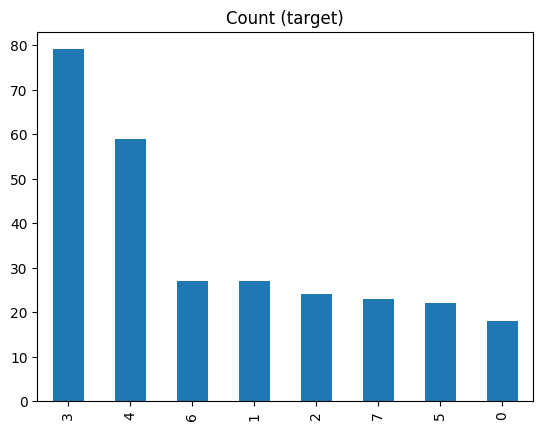

In [51]:
train_y.value_counts().plot(kind='bar', title='Count (target)');
train_y.value_counts()

### SMOTE

c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\imblearn\over_sampling\_smote\base.py:363: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


3    79
0    79
4    59
6    27
1    27
2    24
7    23
5    22
Name: emotion, dtype: int64

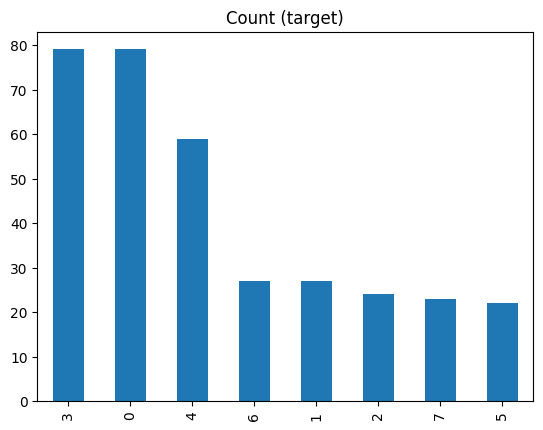

In [52]:
#  SMOTE - BALANCING DATA non-Deep Learning

from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='minority', n_jobs=-1)
smote_X, smote_y = smote.fit_resample(train_x, train_y)

smote_y.value_counts().plot(kind='bar', title='Count (target)');
smote_y.value_counts()

In [53]:
print("Jumlah data baru : ")
smote_y.count()-train_y.count()

Jumlah data baru : 


61

In [54]:
# membuat array models berisikan model yang akan digunakan untuk tahap kedua (SMOTE) dan ketiga (Hyperparameter Tuning)
models = [
    DecisionTreeClassifier(criterion="entropy", max_depth=12),
    RandomForestClassifier(),
    LogisticRegression(
        #penalty='l1',
        C=0.1,
        solver='lbfgs', 
        max_iter=10000
    ),
    SVC(),
    KNeighborsClassifier(n_neighbors=25),
    XGBClassifier(max_depth=2, gamma=2, eta=0.8, reg_alpha=0.5, reg_lambda=0.5),
]
voting_classifier = VotingClassifier(estimators=[('model_'+str(i), models[i]) for i in range(len(models))], voting='hard')
models.append(voting_classifier)

### Fungsi get_metrics_summary (mendapat summary kinerja keseluruhan model)

fungsi untuk mendapatkan gambaran awal mengenai kinerja model dengan strategi stratified k-fold (skoring menggunakan akurasi 'accuracy'), sekaligus dengan performa model terhadap data test

In [55]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# fungsi get_metrics_summary
# -> akan menyimpan nama model dan output/metrik tiap model dalam bentuk :
#     - akurasi pada data train, 
#     - akurasi pada data test, 
#     - rata-rata akurasi cross-validation
#     - standar deviasi akurasi cross-validation 

def get_metrics_summary(models, X_train, X_test, y_train, y_test):
  global models_arr

  # Inisiasi variable kosong
  models_arr = []
  clf_name = []
  train_acc = []
  test_acc = []
  cv_mean = []
  cv_std = []

  # Loop untuk mendapatkan summary metrik tiap model
  for model in models:
    model_fit = model.fit(X_train, y_train)
    models_arr.append(model_fit)
    clf_name.append(model.__class__.__name__)
    y_pred = model.predict(X_test)
    train_acc.append(model.score(X_train, y_train))
    test_acc.append(model.score(X_test, y_test))
    cv_mean.append(cross_val_score(model, X_train, y_train, cv = skf, scoring="accuracy").mean())
    cv_std.append(cross_val_score(model, X_train, y_train, cv = skf, scoring="accuracy").std())

  #Dataframe
  models = pd.DataFrame({
    'Model': clf_name,
    'Train Accuracy': train_acc,
    'Test Accuracy': test_acc,
    'CV mean': cv_mean,
    'CV std': cv_std
    })
  
  models = models.sort_values(by = 'Test Accuracy', ascending = False)

  return models

In [56]:
get_metrics_summary_result = get_metrics_summary(models, smote_X, test_x, smote_y, test_y)
get_metrics_summary_result

c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

,Model,Train Accuracy,Test Accuracy,CV mean,CV std
1,RandomForestClassifier,0.808824,0.341667,0.432353,0.034300
6,VotingClassifier,0.591176,0.333333,0.373529,0.034047
0,DecisionTreeClassifier,0.808824,0.325000,0.394118,0.057334
5,XGBClassifier,0.517647,0.325000,0.364706,0.043026
4,KNeighborsClassifier,0.408824,0.308333,0.297059,0.034047
2,LogisticRegression,0.352941,0.275000,0.276471,0.039896
3,SVC,0.252941,0.100000,0.238235,0.017150


berdasarkan hasil akurasi dengan k-fold di atas, dipilih 2 model 'terbaik', yaitu Random Forest dan XGBoost untuk dilakukan hyperparameter tuning

### Hyperparameter Tuning (Random Forest & XGBoost)

In [57]:
# Hyperparameter Tuning (HT)

# import library
from sklearn.model_selection import RandomizedSearchCV

#### Random Forest

In [58]:
# HT Random Forest

parameters_rf = {
    'n_estimators' : [50, 100, 150, 200, 250, 300, 350, 400, 450, 550, 650, 750, 850, 950, 1000],
    'criterion'         : ['gini', 'entropy'],
    'max_features'      : ['sqrt','log2',0.2,0.5,0.8],
    'max_depth'         : [3,4,6,10],
    'min_samples_split' : [2, 5, 20,50]
}

rf_ht = RandomizedSearchCV(estimator = RandomForestClassifier(), param_distributions = parameters_rf, cv = skf, n_iter = 10,
                           scoring = 'accuracy', verbose = 5, return_train_score = True, random_state = 0)
rf_ht.fit(smote_X, smote_y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[CV 1/5] END criterion=entropy, max_depth=4, max_features=0.2, min_samples_split=20, n_estimators=200;, score=(train=0.485, test=0.294) total time=   0.3s
[CV 2/5] END criterion=entropy, max_depth=4, max_features=0.2, min_samples_split=20, n_estimators=200;, score=(train=0.493, test=0.397) total time=   0.3s
[CV 3/5] END criterion=entropy, max_depth=4, max_features=0.2, min_samples_split=20, n_estimators=200;, score=(train=0.496, test=0.426) total time=   0.3s
[CV 4/5] END criterion=entropy, max_depth=4, max_features=0.2, min_samples_split=20, n_estimators=200;, score=(train=0.540, test=0.426) total time=   0.3s
[CV 5/5] END criterion=entropy, max_depth=4, max_features=0.2, min_samples_split=20, n_estimators=200;, score=(train=0.511, test=0.353) total time=   0.2s
[CV 1/5] END criterion=gini, max_depth=6, max_features=0.5, min_samples_split=50, n_estimators=650;, score=(train=0.500, test=0.324) total time=   1.0s
[CV 2/5] END criterion=gini, max_depth=6, max_features=0.5, min_samples_s

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
                   estimator=RandomForestClassifier(),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [3, 4, 6, 10],
                                        'max_features': ['sqrt', 'log2', 0.2,
                                                         0.5, 0.8],
                                        'min_samples_split': [2, 5, 20, 50],
                                        'n_estimators': [50, 100, 150, 200, 250,
                                                         300, 350, 400, 450,
                                                         550, 650, 750, 850,
                                                         950, 1000]},
                   random_state=0, return_train_score=True, scoring='accuracy',
                   verbose=5)

In [59]:
y_rf_ht = rf_ht.predict(test_x)
print(rf_ht.best_params_)
print(classification_report(test_y, y_rf_ht))
print(rf_ht.score(smote_X, smote_y), rf_ht.score(test_x, test_y))


{'n_estimators': 950, 'min_samples_split': 2, 'max_features': 0.2, 'max_depth': 10, 'criterion': 'gini'}
              precision    recall  f1-score   support

           0       0.17      0.40      0.24        10
           1       0.23      0.43      0.30         7
           2       0.67      0.43      0.52        14
           3       0.48      0.48      0.48        33
           4       0.46      0.52      0.49        25
           5       0.17      0.07      0.10        14
           6       0.00      0.00      0.00        11
           7       0.20      0.17      0.18         6

    accuracy                           0.37       120
   macro avg       0.30      0.31      0.29       120
weighted avg       0.37      0.37      0.35       120

0.8088235294117647 0.36666666666666664


##### Feature Importance Random Forest

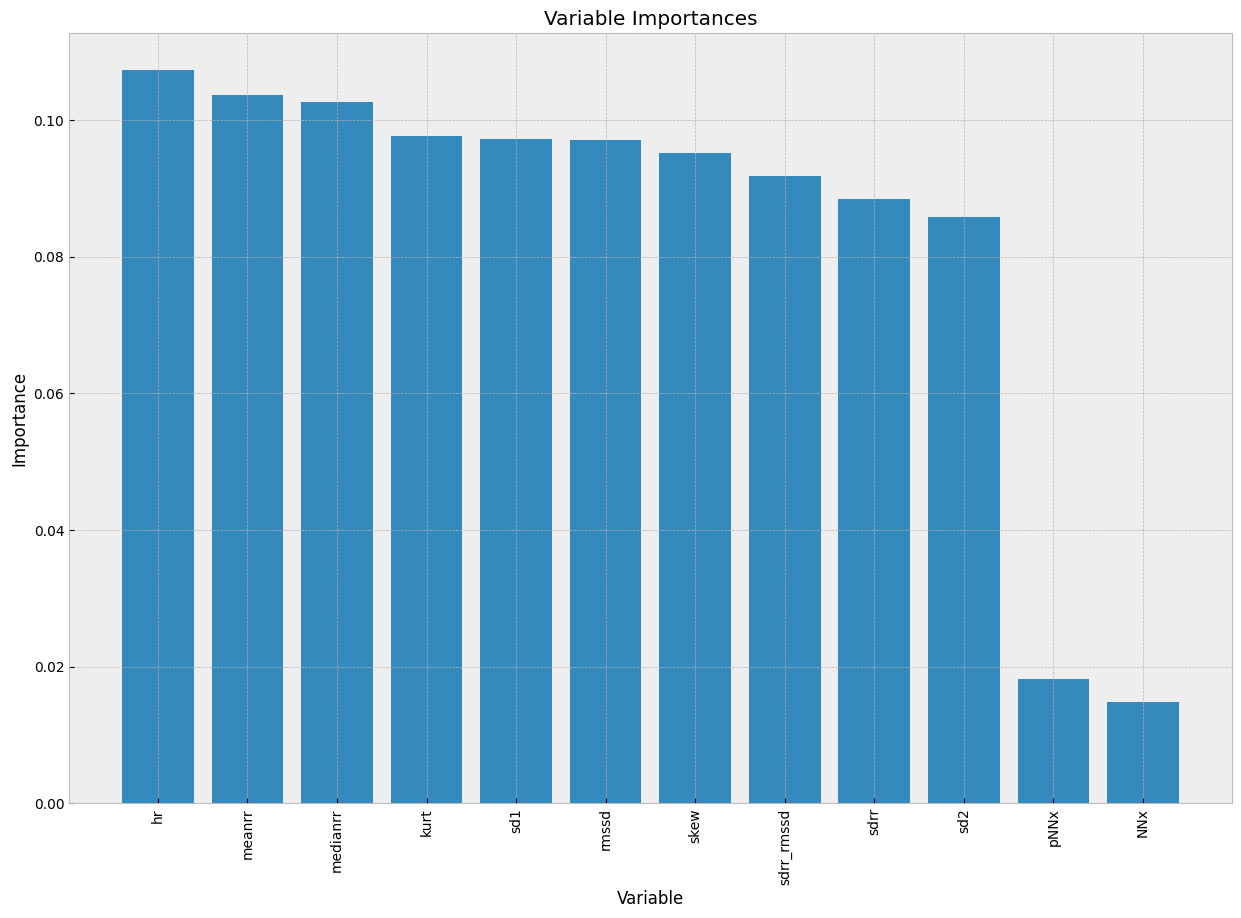

In [60]:
# Feature Importance dari RandomForest

importances = rf_ht.best_estimator_.feature_importances_
feature_list = list(smote_X.columns)
feature_importance= sorted(zip(importances, feature_list), reverse=True)

df = pd.DataFrame(feature_importance, columns=['importance', 'feature'])
importance= list(df['importance'])
feature= list(df['feature'])

plt.style.use('bmh')
x_values = list(range(len(feature_importance)))
plt.figure(figsize=(15,10))
plt.bar(x_values, importance, orientation = 'vertical')
plt.xticks(x_values, feature, rotation='vertical')
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

#### XGBoost

In [61]:
# HT XGBoost

# import library
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [62]:
parameters_xgb={'max_depth': [3, 18, 1],
        'gamma': [1,9],
        'reg_alpha' : [40,180,1],
        'reg_lambda' : [ 0,1],
        'colsample_bytree' : [0.5,1],
        'min_child_weight' : [0, 10, 1],
        'n_estimators':[ 180],
        'seed': [0]
    }
param_xgb = {
    'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400],
    'max_depth': [2, 3, 4, 5, 6, 7, 8],
    'learning_rate': [0.005, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
    'min_child_weight' : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'booster' : ['gbtree', 'dart'],
    'tree_method' : ['auto', 'exact', 'approx', 'hist', 'gpu_hist'],
    'base_score' : [0.25, 0.5, 0.75, 0.1],
    'reg_alpha' : [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
    'reg_lambda' : [0, 1e-1, 1, 5, 10, 20, 50, 100],
    'gamma' : [0.5, 1, 1.5, 2, 5]
    }

xgb_ht = RandomizedSearchCV(estimator = XGBClassifier(), param_distributions = param_xgb, cv = skf, n_iter = 15,
                           scoring = 'accuracy', verbose = 5, return_train_score = True, random_state = 0)
xgb_ht.fit(smote_X, smote_y)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:15:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:20:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\Dell\AppData\Local\Programs\Python\Python311\Li

[CV 1/5] END base_score=0.25, booster=dart, gamma=0.5, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=400, reg_alpha=1, reg_lambda=0, tree_method=gpu_hist;, score=(train=0.676, test=0.397) total time= 4.4min


c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:20:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:23:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV 2/5] END base_score=0.25, booster=dart, gamma=0.5, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=400, reg_alpha=1, reg_lambda=0, tree_method=gpu_hist;, score=(train=0.636, test=0.441) total time= 3.7min


c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:23:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:29:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV 3/5] END base_score=0.25, booster=dart, gamma=0.5, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=400, reg_alpha=1, reg_lambda=0, tree_method=gpu_hist;, score=(train=0.658, test=0.353) total time= 5.4min


c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:29:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:34:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV 4/5] END base_score=0.25, booster=dart, gamma=0.5, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=400, reg_alpha=1, reg_lambda=0, tree_method=gpu_hist;, score=(train=0.673, test=0.397) total time= 5.1min


c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:34:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:41:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV 5/5] END base_score=0.25, booster=dart, gamma=0.5, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=400, reg_alpha=1, reg_lambda=0, tree_method=gpu_hist;, score=(train=0.662, test=0.338) total time= 6.9min
[CV 1/5] END base_score=0.1, booster=dart, gamma=5, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=200, reg_alpha=50, reg_lambda=50, tree_method=exact;, score=(train=0.232, test=0.235) total time=  11.5s
[CV 2/5] END base_score=0.1, booster=dart, gamma=5, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=200, reg_alpha=50, reg_lambda=50, tree_method=exact;, score=(train=0.232, test=0.235) total time=  13.2s
[CV 3/5] END base_score=0.1, booster=dart, gamma=5, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=200, reg_alpha=50, reg_lambda=50, tree_method=exact;, score=(train=0.232, test=0.235) total time=  11.1s
[CV 4/5] END base_score=0.1, booster=dart, gamma=5, learning_rate=0.01, max_depth=6, min_child_weight=2,

c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:42:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:42:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\Dell\AppData\Local\Programs\Python\Python311\Li

[CV 1/5] END base_score=0.25, booster=gbtree, gamma=1, learning_rate=0.05, max_depth=8, min_child_weight=10, n_estimators=100, reg_alpha=0, reg_lambda=10, tree_method=gpu_hist;, score=(train=0.482, test=0.324) total time=   1.5s


c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:42:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:42:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV 2/5] END base_score=0.25, booster=gbtree, gamma=1, learning_rate=0.05, max_depth=8, min_child_weight=10, n_estimators=100, reg_alpha=0, reg_lambda=10, tree_method=gpu_hist;, score=(train=0.474, test=0.397) total time=   0.7s


c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:42:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:42:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV 3/5] END base_score=0.25, booster=gbtree, gamma=1, learning_rate=0.05, max_depth=8, min_child_weight=10, n_estimators=100, reg_alpha=0, reg_lambda=10, tree_method=gpu_hist;, score=(train=0.467, test=0.324) total time=   0.8s


c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:42:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:42:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV 4/5] END base_score=0.25, booster=gbtree, gamma=1, learning_rate=0.05, max_depth=8, min_child_weight=10, n_estimators=100, reg_alpha=0, reg_lambda=10, tree_method=gpu_hist;, score=(train=0.467, test=0.324) total time=   0.8s


c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:42:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV 5/5] END base_score=0.25, booster=gbtree, gamma=1, learning_rate=0.05, max_depth=8, min_child_weight=10, n_estimators=100, reg_alpha=0, reg_lambda=10, tree_method=gpu_hist;, score=(train=0.518, test=0.309) total time=   0.9s
[CV 1/5] END base_score=0.75, booster=gbtree, gamma=5, learning_rate=0.005, max_depth=2, min_child_weight=2, n_estimators=300, reg_alpha=10, reg_lambda=1, tree_method=exact;, score=(train=0.309, test=0.265) total time=   0.7s
[CV 2/5] END base_score=0.75, booster=gbtree, gamma=5, learning_rate=0.005, max_depth=2, min_child_weight=2, n_estimators=300, reg_alpha=10, reg_lambda=1, tree_method=exact;, score=(train=0.305, test=0.309) total time=   0.8s
[CV 3/5] END base_score=0.75, booster=gbtree, gamma=5, learning_rate=0.005, max_depth=2, min_child_weight=2, n_estimators=300, reg_alpha=10, reg_lambda=1, tree_method=exact;, score=(train=0.305, test=0.265) total time=   0.8s
[CV 4/5] END base_score=0.75, booster=gbtree, gamma=5, learning_rate=0.005, max_depth=2, min_

c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:44:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:44:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\Dell\AppData\Local\Programs\Python\Python311\Li

[CV 1/5] END base_score=0.25, booster=gbtree, gamma=5, learning_rate=0.2, max_depth=8, min_child_weight=5, n_estimators=100, reg_alpha=50, reg_lambda=0.1, tree_method=gpu_hist;, score=(train=0.232, test=0.235) total time=   2.1s


c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:44:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:44:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV 2/5] END base_score=0.25, booster=gbtree, gamma=5, learning_rate=0.2, max_depth=8, min_child_weight=5, n_estimators=100, reg_alpha=50, reg_lambda=0.1, tree_method=gpu_hist;, score=(train=0.232, test=0.235) total time=   1.2s


c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:44:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV 3/5] END base_score=0.25, booster=gbtree, gamma=5, learning_rate=0.2, max_depth=8, min_child_weight=5, n_estimators=100, reg_alpha=50, reg_lambda=0.1, tree_method=gpu_hist;, score=(train=0.232, test=0.235) total time=   1.8s


c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:44:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:44:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\Dell\AppData\Local\Programs\Python\Python311\Li

[CV 4/5] END base_score=0.25, booster=gbtree, gamma=5, learning_rate=0.2, max_depth=8, min_child_weight=5, n_estimators=100, reg_alpha=50, reg_lambda=0.1, tree_method=gpu_hist;, score=(train=0.232, test=0.235) total time=   1.3s


c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:44:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV 5/5] END base_score=0.25, booster=gbtree, gamma=5, learning_rate=0.2, max_depth=8, min_child_weight=5, n_estimators=100, reg_alpha=50, reg_lambda=0.1, tree_method=gpu_hist;, score=(train=0.235, test=0.221) total time=   1.6s
[CV 1/5] END base_score=0.1, booster=dart, gamma=1.5, learning_rate=0.25, max_depth=3, min_child_weight=10, n_estimators=300, reg_alpha=10, reg_lambda=20, tree_method=approx;, score=(train=0.309, test=0.265) total time=  39.7s
[CV 2/5] END base_score=0.1, booster=dart, gamma=1.5, learning_rate=0.25, max_depth=3, min_child_weight=10, n_estimators=300, reg_alpha=10, reg_lambda=20, tree_method=approx;, score=(train=0.301, test=0.309) total time=  33.8s
[CV 3/5] END base_score=0.1, booster=dart, gamma=1.5, learning_rate=0.25, max_depth=3, min_child_weight=10, n_estimators=300, reg_alpha=10, reg_lambda=20, tree_method=approx;, score=(train=0.309, test=0.265) total time=  24.8s
[CV 4/5] END base_score=0.1, booster=dart, gamma=1.5, learning_rate=0.25, max_depth=3, min

c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:47:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:47:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\Dell\AppData\Local\Programs\Python\Python311\Li

[CV 1/5] END base_score=0.25, booster=gbtree, gamma=0.5, learning_rate=0.01, max_depth=8, min_child_weight=1, n_estimators=50, reg_alpha=5, reg_lambda=0, tree_method=gpu_hist;, score=(train=0.500, test=0.382) total time=   1.4s


c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:47:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:47:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV 2/5] END base_score=0.25, booster=gbtree, gamma=0.5, learning_rate=0.01, max_depth=8, min_child_weight=1, n_estimators=50, reg_alpha=5, reg_lambda=0, tree_method=gpu_hist;, score=(train=0.441, test=0.309) total time=   0.5s


c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:47:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:47:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV 3/5] END base_score=0.25, booster=gbtree, gamma=0.5, learning_rate=0.01, max_depth=8, min_child_weight=1, n_estimators=50, reg_alpha=5, reg_lambda=0, tree_method=gpu_hist;, score=(train=0.500, test=0.324) total time=   0.6s


c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:47:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:47:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV 4/5] END base_score=0.25, booster=gbtree, gamma=0.5, learning_rate=0.01, max_depth=8, min_child_weight=1, n_estimators=50, reg_alpha=5, reg_lambda=0, tree_method=gpu_hist;, score=(train=0.500, test=0.353) total time=   0.6s


c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:47:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV 5/5] END base_score=0.25, booster=gbtree, gamma=0.5, learning_rate=0.01, max_depth=8, min_child_weight=1, n_estimators=50, reg_alpha=5, reg_lambda=0, tree_method=gpu_hist;, score=(train=0.460, test=0.294) total time=   0.5s
[CV 1/5] END base_score=0.25, booster=gbtree, gamma=1, learning_rate=0.25, max_depth=2, min_child_weight=4, n_estimators=300, reg_alpha=2, reg_lambda=10, tree_method=hist;, score=(train=0.485, test=0.324) total time=   0.3s
[CV 2/5] END base_score=0.25, booster=gbtree, gamma=1, learning_rate=0.25, max_depth=2, min_child_weight=4, n_estimators=300, reg_alpha=2, reg_lambda=10, tree_method=hist;, score=(train=0.441, test=0.324) total time=   0.3s
[CV 3/5] END base_score=0.25, booster=gbtree, gamma=1, learning_rate=0.25, max_depth=2, min_child_weight=4, n_estimators=300, reg_alpha=2, reg_lambda=10, tree_method=hist;, score=(train=0.456, test=0.353) total time=   0.3s
[CV 4/5] END base_score=0.25, booster=gbtree, gamma=1, learning_rate=0.25, max_depth=2, min_child_we

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importanc...
                                        'learning_rate': [0.005, 0.01, 0.05,
                                                          0.1, 0.15, 0.2, 0.25,
                                                          0.3],
                                        'max_depth': [2, 3, 4, 5, 6, 7, 8],
                                        'min_child_weight': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, 10],
                                        'n_estimators': [50, 100, 150, 200, 250,
                                                         300, 350, 400],
                                        'reg_alpha': [0, 0.1, 1, 2, 5, 7, 10,
                                                      50, 100],
                                        'reg_lambda': [0, 0.1, 1, 5, 10, 20, 50,
                                                       100],
                                        'tree_method': ['auto', 'exact',
                                                        'approx', 'hist',
                                                        'gpu_hist']},
                   random_state=0, return_train_score=True, scoring='accuracy',
                   verbose=5)

In [63]:
y_xgb_ht = xgb_ht.predict(test_x)
print(xgb_ht.best_params_)
print(classification_report(test_y, y_xgb_ht))
print(xgb_ht.score(smote_X, smote_y), xgb_ht.score(test_x, test_y))


{'tree_method': 'exact', 'reg_lambda': 1, 'reg_alpha': 0.1, 'n_estimators': 150, 'min_child_weight': 2, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 1, 'booster': 'dart', 'base_score': 0.1}
              precision    recall  f1-score   support

           0       0.16      0.40      0.23        10
           1       0.20      0.29      0.24         7
           2       0.67      0.43      0.52        14
           3       0.43      0.45      0.44        33
           4       0.41      0.48      0.44        25
           5       0.00      0.00      0.00        14
           6       1.00      0.09      0.17        11
           7       0.00      0.00      0.00         6

    accuracy                           0.33       120
   macro avg       0.36      0.27      0.25       120
weighted avg       0.40      0.33      0.32       120

0.7058823529411765 0.3333333333333333


##### Feature Importance XGBoost

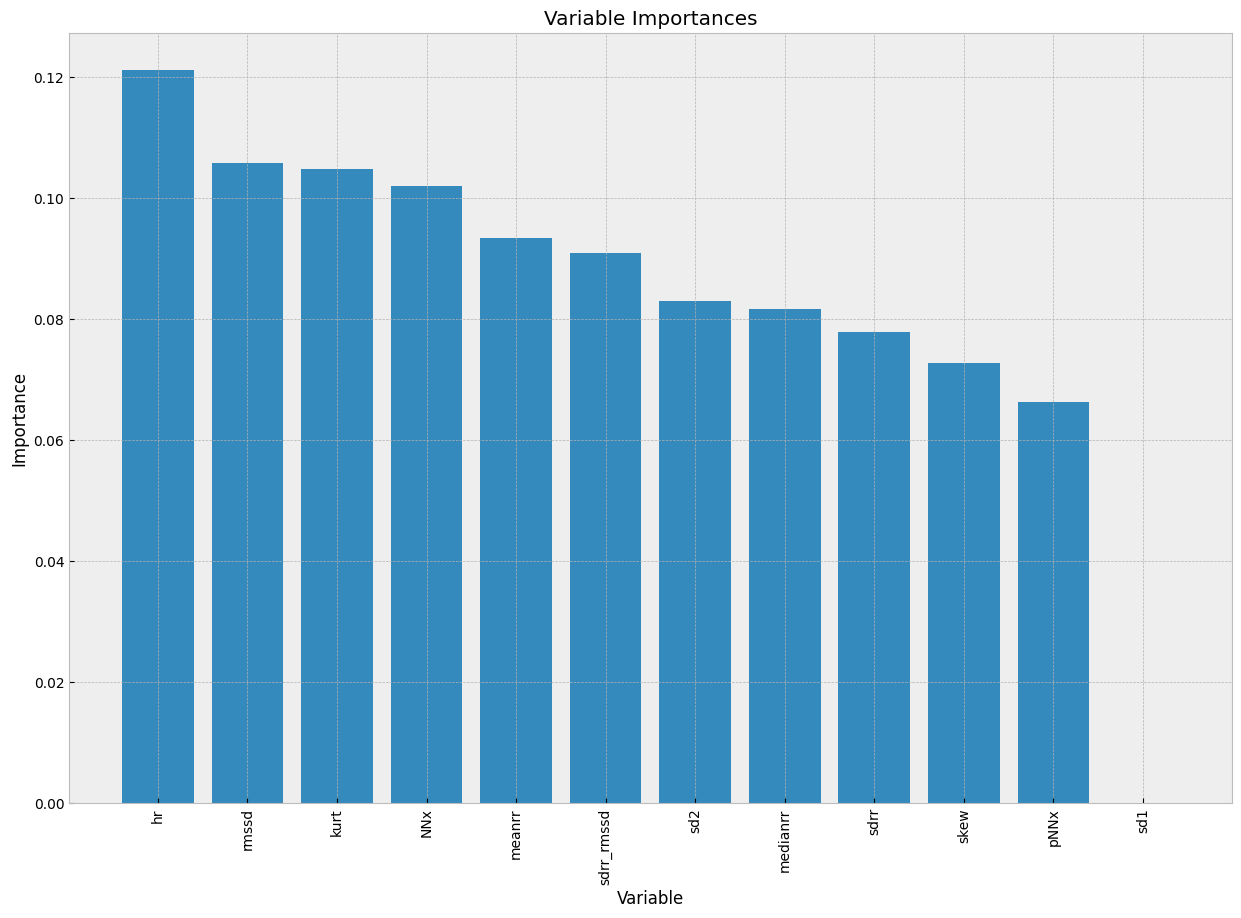

In [64]:
importances = xgb_ht.best_estimator_.feature_importances_
feature_list = list(smote_X.columns)
feature_importance= sorted(zip(importances, feature_list), reverse=True)

df = pd.DataFrame(feature_importance, columns=['importance', 'feature'])
importance= list(df['importance'])
feature= list(df['feature'])

plt.style.use('bmh')
x_values = list(range(len(feature_importance)))
plt.figure(figsize=(15,10))
plt.bar(x_values, importance, orientation = 'vertical')
plt.xticks(x_values, feature, rotation='vertical')
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

In [65]:
import pickle
filename = 'best_model.sav'
pickle.dump(xgb_ht, open(filename, 'wb'))